# 1. Downloading python scripts to ease the training of the models 
github hosted

In [1]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend 
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [5]:
from drive.MyDrive.gitclone.BachelorArbeit_pre.Pytorch_Modules import data_setup, helper_functions, train_step

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
import os
from pathlib import Path
dataset_path = Path("/content/drive/My Drive/Dataset")
helper_functions.walk_through_dir(dataset_path)

Found 2 directories and 0 Images in /content/drive/My Drive/Dataset
Found 3 directories and 0 Images in /content/drive/My Drive/Dataset/train
Found 0 directories and 307 Images in /content/drive/My Drive/Dataset/train/Nose
Found 0 directories and 220 Images in /content/drive/My Drive/Dataset/train/Ear
Found 0 directories and 112 Images in /content/drive/My Drive/Dataset/train/VocalFolds
Found 3 directories and 0 Images in /content/drive/My Drive/Dataset/test
Found 0 directories and 128 Images in /content/drive/My Drive/Dataset/test/Nose
Found 0 directories and 37 Images in /content/drive/My Drive/Dataset/test/Ear
Found 0 directories and 78 Images in /content/drive/My Drive/Dataset/test/VocalFolds


# 2. create datasets and dataloaders

to use `torchvision.models` the image has to be loaded in to a range of [0,1] and the normalized using  mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

* genarally you should take a look on the docu and check the requierd shape, pixel values, mean and standard daviation and include them while transforming

In [8]:
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # this includes scaling the pixel values 0..1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

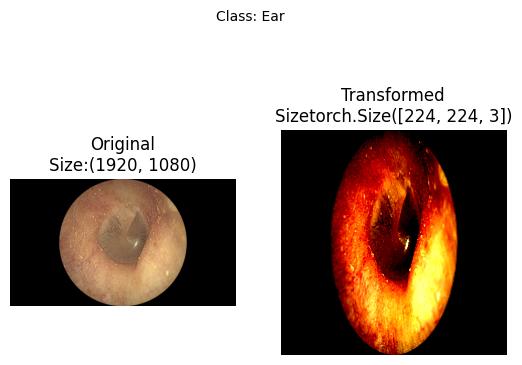

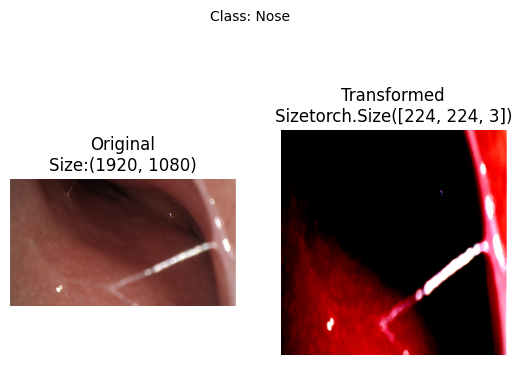

In [9]:
image_path_list = list(dataset_path.glob("*/*/*.png"))
helper_functions.plot_transformed_images(image_path_list, manual_transforms, 2)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fbcd11f6b30>,
 ['Ear', 'Nose', 'VocalFolds'])

## 2.2 creating autotransforms from `torchvision.model`

In [11]:
# get the weights of the pretraind model 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms
auto_transforms, weights, weights.get_state_dict(False).keys()

(functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, resize_size=256, interpolation=<InterpolationMode.BICUBIC: 'bicubic'>),
 EfficientNet_B0_Weights.IMAGENET1K_V1,
 odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1.0.block.1.fc2.weight', 'features.1.0.block.1.fc2.bias', 'features.1.0.block.2.0.weight', 'features.1.0.block.2.1.weight', 'features.1.0.block.2.1.bias', 'features.1.0.block.2.1.running_mean', 'features.1.0.block.2.1.running_var', 'features.1.0.block.2.1.num_batches_tracked', 'features.2.0.block.0.0.weight', 'features

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fbccf99eaa0>,
 ['Ear', 'Nose', 'VocalFolds'])

# 3. getting a pretrained model

In [13]:
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
summary(model=model_1, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## 3.1 Adjusting the out features of the model to suite my case

In [15]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.
for param in model_1.features.parameters():
    param.requires_grad = False

In [16]:
# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

In [17]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# train the model

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [19]:
from timeit import default_timer as timer
start_time = timer()
results = train_step.train(model=model_1,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=2,
                           device=device)
end_time = timer()
print(f"total training time: {end_time-start_time:.3f} secconds")

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5605 | train_acc: 87.66% | test_loss: 0.5863 | test_acc: 76.83%
Epoch: 2 | train_loss: 0.1569 | train_acc: 98.44% | test_loss: 0.2437 | test_acc: 93.69%
total training time: 267.715 secconds


In [20]:
range(len(results))
results

{'train_loss': [0.560472970455885, 0.15689413882791997],
 'train_acc': [87.65625, 98.4375],
 'test_loss': [0.5863338559865952, 0.24371404480189085],
 'test_acc': [76.8297697368421, 93.68832236842105]}

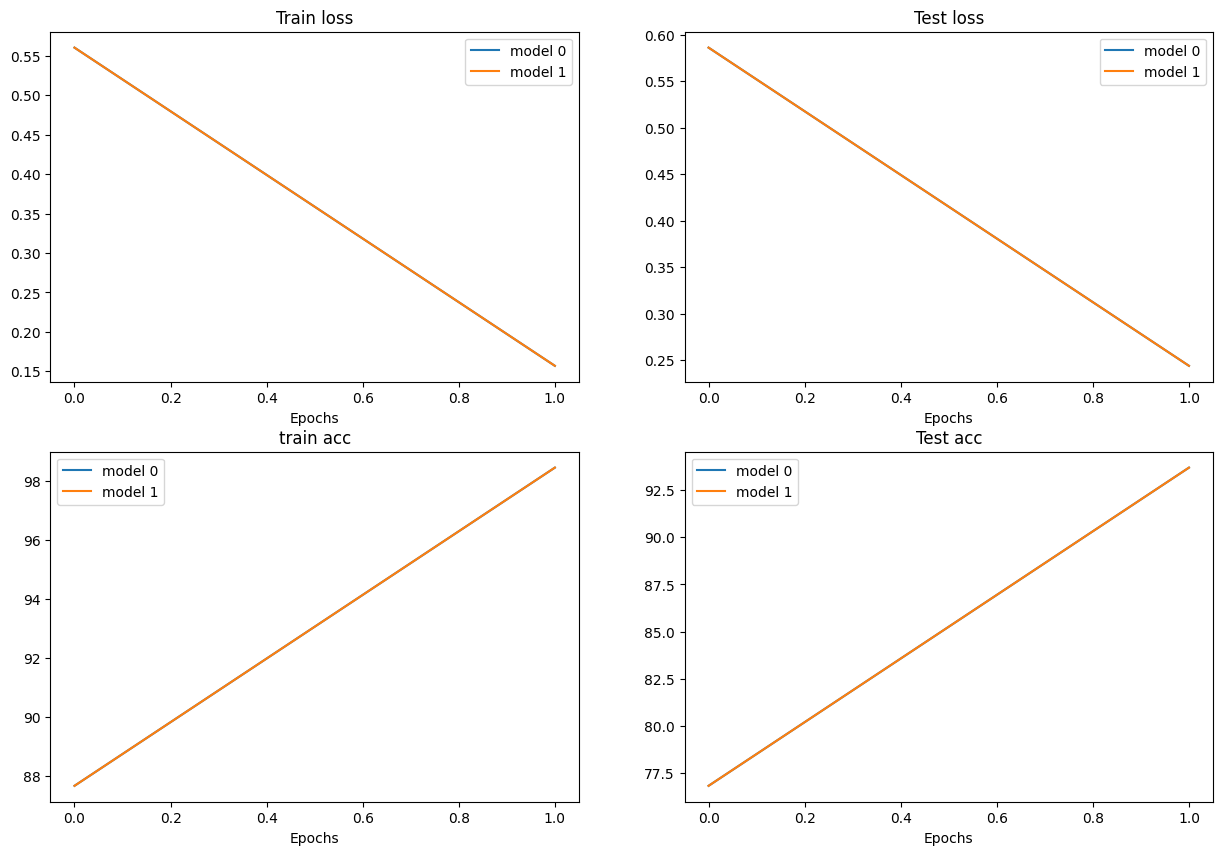

In [21]:
helper_functions.compare_loss_curves(results, results)

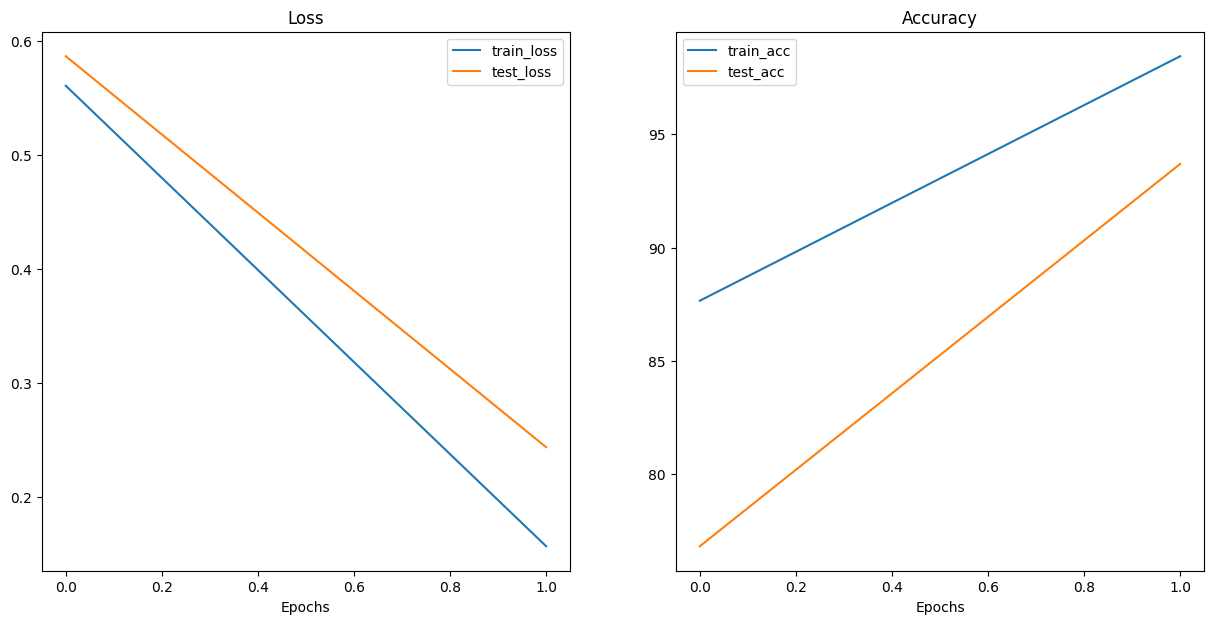

In [22]:
helper_functions.plot_loss_curves(results)

Random image path: /content/drive/My Drive/Dataset/train/VocalFolds/strobo_1_0039.png
Image Class: VocalFolds
Image height: 1080
Image width: 1920


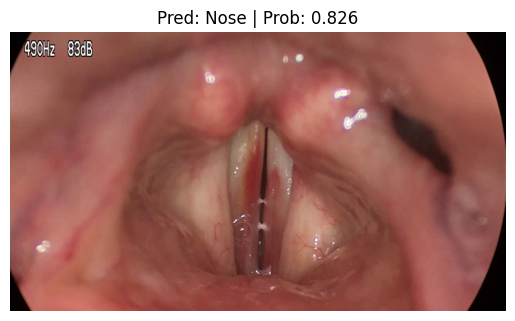

In [23]:
img, path = helper_functions.get_random_image_from_dir(dataset_path)
helper_functions.predict_on_custom(model=model_1,
                  img_path=path,
                  class_names=class_names,
                  target_size=224,
                  device=device)

In [24]:
test_preds, targets_preds = helper_functions.make_predictions(test_dataloader, model_1, device)


Making predictions:   0%|          | 0/8 [00:00<?, ?it/s]

In [26]:
helper_functions.plot_confusion(targets_preds, test_preds, class_names)

AttributeError: ignored

In [ ]:
preds_tensor, targets_tensor = helper_functions.make_predictions(train_dataloader, model_1, device)
helper_functions.plot_confusion(targets_tensor, preds_tensor, class_names)

In [ ]:
!ls "/content/drive/My Drive/NewExamples/ImagesFromTheInternet"

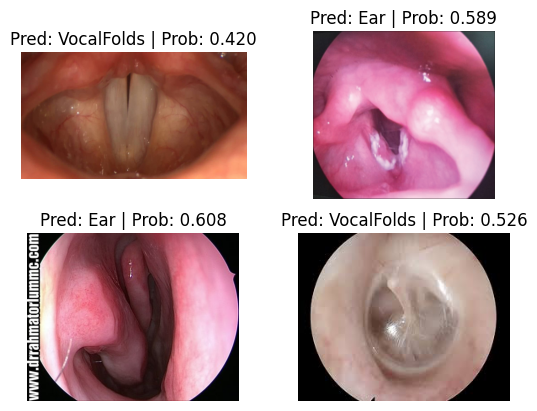

In [27]:
plt.subplot(2,2,1)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Folds_1.png",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2,2,2)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Folds_3.jpg",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2, 2, 3)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Nose_5.jpg",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2,2,4)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Ear_5.jfif",
                  class_names=class_names,
                  target_size=64,
                  device=device)